<a href="https://colab.research.google.com/github/crazyprags/Heart-Rate-Detection-and-Classification/blob/main/Heart_Rate_Detection_%26_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [97]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/mimic_perform_train_all_001_data.csv')

In [98]:
df.head()

,Time,PPG,ECG,resp
0,0.000,1.360704,0.455078,1.750153
1,0.008,1.394917,0.404785,1.750153
2,0.016,1.444770,0.339844,1.750153
3,0.024,1.508309,0.300293,1.750153
4,0.032,1.581623,0.285156,1.624924


In [99]:
time_data = df['Time'].values
ppg_signal = df['PPG'].values
ecg_signal = df['ECG'].values
resp_signal = df['resp'].values

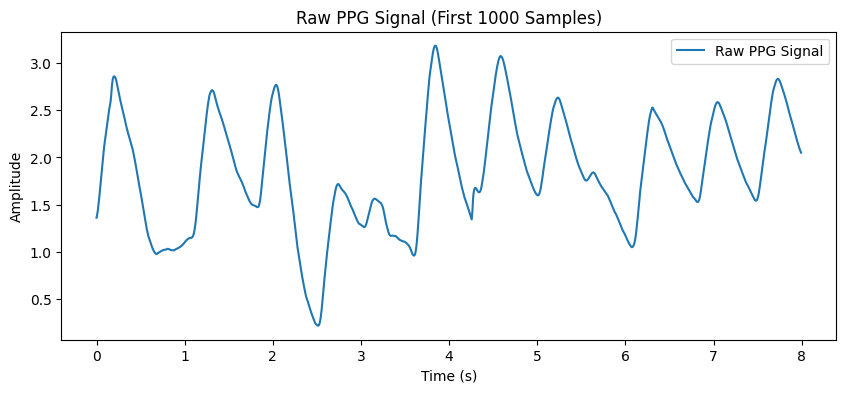

In [100]:
plt.figure(figsize=(10, 4))
plt.plot(time_data[:1000], ppg_signal[:1000], label="Raw PPG Signal")
plt.title("Raw PPG Signal (First 1000 Samples)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [101]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b,a

def apply_filter(ppg_data, lowcut=0.5, highcut=3.5, fs=100):
    b, a = butter_bandpass(lowcut, highcut, fs, order=5)
    filtered_data = filtfilt(b, a, ppg_data)
    return filtered_data

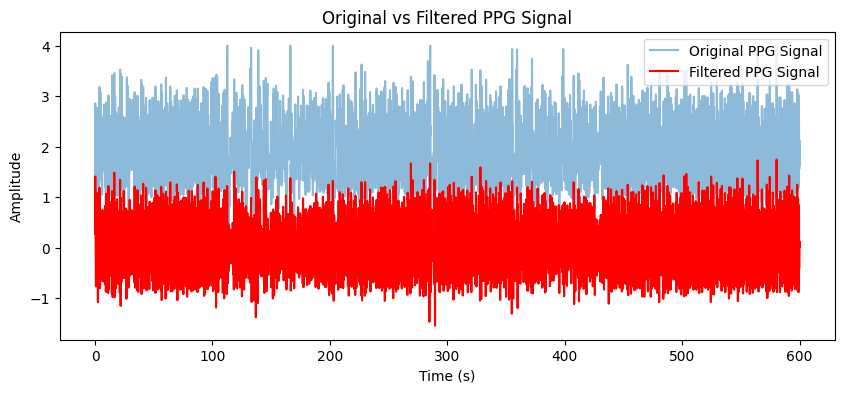

In [102]:
fs = 125

filtered_data = apply_filter(ppg_signal, fs=fs)

plt.figure(figsize=(10, 4))
plt.plot(time_data, ppg_signal, label="Original PPG Signal", alpha=0.5)
plt.plot(time_data, filtered_data, label="Filtered PPG Signal", color='red')
plt.title("Original vs Filtered PPG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

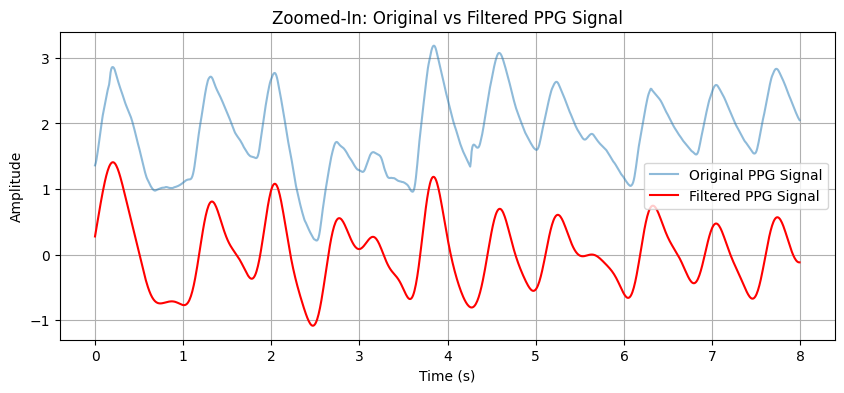

In [103]:
start = 0
end = 1000
plt.figure(figsize=(10, 4))
plt.plot(time_data[start:end], ppg_signal[start:end], label="Original PPG Signal", alpha=0.5)
plt.plot(time_data[start:end], filtered_data[start:end], label="Filtered PPG Signal", color='red')
plt.title("Zoomed-In: Original vs Filtered PPG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [104]:
def heart_rate_extraction(filtered_data, time_data, fs):
  peaks, _ = find_peaks(filtered_data, distance=fs//2)
  peak_intervals = np.diff(time_data[peaks])
  heart_rate = 60 / np.mean(peak_intervals) if len(peak_intervals) > 0 else 0
  return heart_rate, peaks

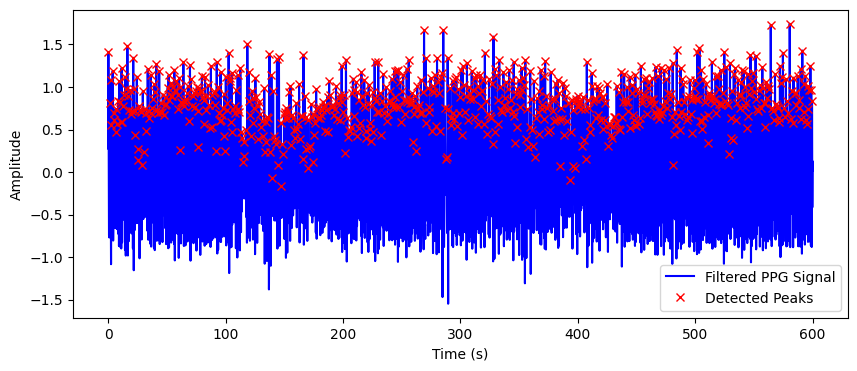

In [105]:
heart_rate, peaks = heart_rate_extraction(filtered_data, time_data, fs)

plt.figure(figsize=(10, 4))
plt.plot(time_data, filtered_data, label="Filtered PPG Signal", color='b')
plt.plot(time_data[peaks], filtered_data[peaks], "rx", label="Detected Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [106]:
heart_rates = []
window_size = fs * 10


for i in range(len(ppg_signal) - window_size + 1):
    filtered_ppg = apply_filter(ppg_signal[i:i + window_size], fs=125)
    heart_rate, _ = heart_rate_extraction(filtered_ppg, time_data[i:i + window_size], fs=125)
    heart_rates.append(heart_rate)



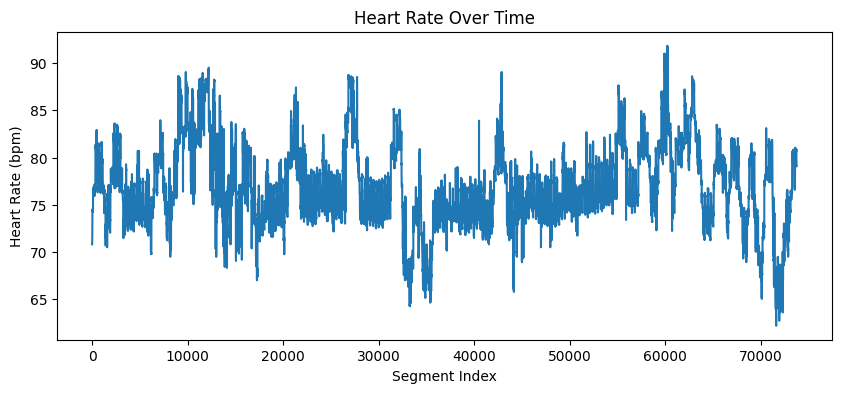

In [107]:
plt.figure(figsize=(10, 4))
plt.plot(heart_rates)
plt.title("Heart Rate Over Time")
plt.xlabel("Segment Index")
plt.ylabel("Heart Rate (bpm)")
plt.show()

In [108]:
def create_labels(heart_rate):
  if(heart_rate < 65): #low
    return 0

  elif(heart_rate >= 65 and heart_rate <= 70): #slight below normal
    return 1

  elif(heart_rate>70 and heart_rate<=72): #slight above normal
    return 2

  else:
    return 3 #very high

In [109]:
labels = []
window_size = 3000

for i in range(len(ppg_signal) - window_size + 1):
    filtered_ppg = apply_filter(ppg_signal[i:i + window_size], fs=125)
    heart_rate, _ = heart_rate_extraction(filtered_ppg, time_data[i:i + window_size], fs=125)
    labels.append(create_labels(heart_rate))


labels = np.array(labels)
unique_labels, counts = np.unique(labels, return_counts=True)
print("Unique Labels:", unique_labels)
print("Label Counts:", counts)

Unique Labels: [1 2 3]
Label Counts: [ 1278  3671 67053]


In [110]:
features_list = []

for i in range(len(ppg_signal) - window_size + 1):
    filtered_ppg = apply_filter(ppg_signal[i:i + window_size], fs=125)
    heart_rate, _ = heart_rate_extraction(filtered_ppg, time_data[i:i + window_size], fs=125)


    peak_intervals = np.diff(time_data[peaks]) if len(peaks) > 1 else [0]
    mean_ppg_amp, std_ppg_amp = np.mean(ppg_signal[i:i + window_size]), np.std(ppg_signal[i:i + window_size])

    features_list.append({
        'heart_rate': heart_rate,
        'ppg_amplitude_mean': mean_ppg_amp,
        'ppg_amplitude_std': std_ppg_amp,
        'peak_interval_variability': np.std(peak_intervals)
    })


features_df = pd.DataFrame(features_list)

In [111]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.3, random_state=42)


print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (50401, 4), Testing data shape: (21601, 4)


In [112]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape: {X_resampled.shape}")

Resampled dataset shape: (140883, 4)


In [113]:
unique_labels.shape[0]

3

In [114]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [115]:
y_pred = rf_model.predict(X_test)

In [116]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.9f}%")


print("Classification Report:")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Model Accuracy: 100.000000000%
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       387
           2       1.00      1.00      1.00      1122
           3       1.00      1.00      1.00     20092

    accuracy                           1.00     21601
   macro avg       1.00      1.00      1.00     21601
weighted avg       1.00      1.00      1.00     21601

Confusion Matrix:
[[  387     0     0]
 [    0  1122     0]
 [    0     0 20092]]
